In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("WorldDevelopmentIndicators.csv")
print(len(df))
#df.head()
df.info()
df_null = df[df.isnull().any(axis=1)]
print(df_null)
df_nonull = df.dropna()


803
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   800 non-null    object
 1   Country Code   798 non-null    object
 2   Series Name    798 non-null    object
 3   Series Code    798 non-null    object
 4   2015 [YR2015]  798 non-null    object
 5   2016 [YR2016]  798 non-null    object
 6   2017 [YR2017]  798 non-null    object
 7   2018 [YR2018]  798 non-null    object
 8   2019 [YR2019]  798 non-null    object
 9   2020 [YR2020]  798 non-null    object
 10  2021 [YR2021]  798 non-null    object
 11  2022 [YR2022]  798 non-null    object
 12  2023 [YR2023]  798 non-null    object
 13  2024 [YR2024]  798 non-null    object
dtypes: object(14)
memory usage: 88.0+ KB
                                         Country Name Country Code  \
798                                               NaN          NaN   
799                  

In [18]:
print(len(df_nonull))

798


In [19]:
for col in df_nonull.columns:
    if col not in ["Country Name", "Country Code", "Series Name", "Series Code"]:
        df_nonull[col] = pd.to_numeric(df_nonull[col], errors="coerce")
        
df_nonull.head()
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 0 to 797
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   798 non-null    object 
 1   Country Code   798 non-null    object 
 2   Series Name    798 non-null    object 
 3   Series Code    798 non-null    object 
 4   2015 [YR2015]  782 non-null    float64
 5   2016 [YR2016]  778 non-null    float64
 6   2017 [YR2017]  778 non-null    float64
 7   2018 [YR2018]  779 non-null    float64
 8   2019 [YR2019]  778 non-null    float64
 9   2020 [YR2020]  778 non-null    float64
 10  2021 [YR2021]  778 non-null    float64
 11  2022 [YR2022]  777 non-null    float64
 12  2023 [YR2023]  764 non-null    float64
 13  2024 [YR2024]  465 non-null    float64
dtypes: float64(10), object(4)
memory usage: 93.5+ KB


/tmp/ipykernel_183/1556006447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull[col] = pd.to_numeric(df_nonull[col], errors="coerce")


In [20]:
# Reshape to long format
df_long = df_nonull.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=["2015 [YR2015]", "2016 [YR2016]", "2017 [YR2017]",
                "2018 [YR2018]", "2019 [YR2019]", "2020 [YR2020]",
                "2021 [YR2021]", "2022 [YR2022]", "2023 [YR2023]",
                "2024 [YR2024]"],
    var_name="Year_raw",
    value_name="Value"
)

# Extract just the numeric year from "2015 [YR2015]"
df_long["Year"] = df_long["Year_raw"].str.extract(r"(\d{4})").astype(int)

# Drop the old column if you don’t need it
df_long = df_long.drop(columns="Year_raw")
print(len(df_long))
print(df_long.head())
df_long.info()

7980
  Country Name Country Code                              Series Name  \
0  Afghanistan          AFG                    GDP growth (annual %)   
1  Afghanistan          AFG       GDP per capita (constant 2015 US$)   
2  Afghanistan          AFG  Life expectancy at birth, total (years)   
3      Albania          ALB                    GDP growth (annual %)   
4      Albania          ALB       GDP per capita (constant 2015 US$)   

         Series Code        Value  Year  
0  NY.GDP.MKTP.KD.ZG     1.451315  2015  
1     NY.GDP.PCAP.KD   565.569730  2015  
2     SP.DYN.LE00.IN    62.270000  2015  
3  NY.GDP.MKTP.KD.ZG     2.227704  2015  
4     NY.GDP.PCAP.KD  3981.726623  2015  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  7980 non-null   object 
 1   Country Code  7980 non-null   object 
 2   Series Name   7980 non-null

In [29]:
df_pivot = df_long.pivot_table(
    index = ["Country Name", "Country Code","Year"],
    columns = ["Series Name"],
    values = ["Value"],
    #values = ["2015 [YR2015]", "2016 [YR2016]",	"2017 [YR2017]", "2018 [YR2018]", "2019 [YR2019]", "2020 [YR2020]", "2021 [YR2021]", "2022 [YR2022]", "2023 [YR2023]", "2024 [YR2024]"],
    aggfunc="first"
)
#df_pivot.head(20)
df_pivot = df_pivot.reset_index()
df_pivot.columns = [
    col[1] if col[0] == "Value" else col[0]   # keep "Country Name" etc., strip "Value"
    for col in df_pivot.columns
]

# Now fill NaN in GDP per capita per country
df_pivot["GDP per capita (constant 2015 US$)"] = (
    df_pivot.groupby("Country Name")["GDP per capita (constant 2015 US$)"]
            .transform(lambda x: x.fillna(x.mean()))
)

# Fill NaN in Life expectancy at birth, total (years)

df_pivot["Life expectancy at birth, total (years)"] = (
    df_pivot.groupby("Country Name")["Life expectancy at birth, total (years)"]
            .transform(lambda x: x.fillna(x.mean()))
)

# Fill NaN in GDP growth (annual %)
df_pivot["GDP growth (annual %)"] = (
    df_pivot.groupby("Country Name")["GDP growth (annual %)"]
            .transform(lambda x: x.fillna(x.mean()))
)



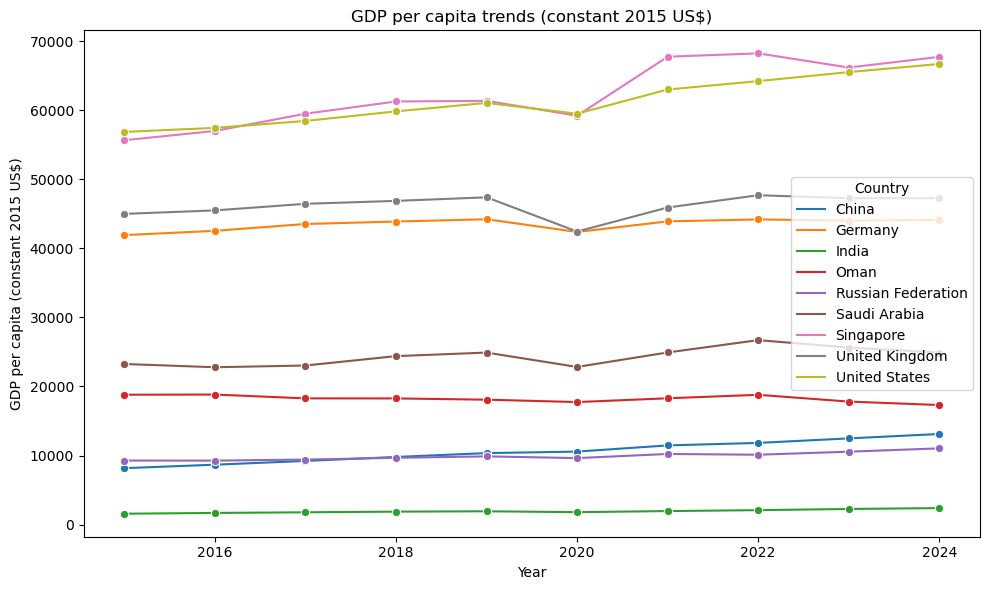

In [30]:


# Select countries by Country Code
countries = ["USA", "CHN", "RUS", "GBR", "DEU", "SAU", "OMN", "SGP", "IND"]
filtered_df = df_pivot[df_pivot["Country Code"].isin(countries)]

# Plot GDP per capita trends
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_df,
    x="Year",
    y="GDP per capita (constant 2015 US$)",  # <-- adjust to your column name
    hue="Country Name",                      # or "Country Code"
    marker="o"
)

plt.title("GDP per capita trends (constant 2015 US$)")
plt.ylabel("GDP per capita (constant 2015 US$)")
plt.xlabel("Year")
plt.legend(title="Country")
plt.tight_layout()
plt.show()

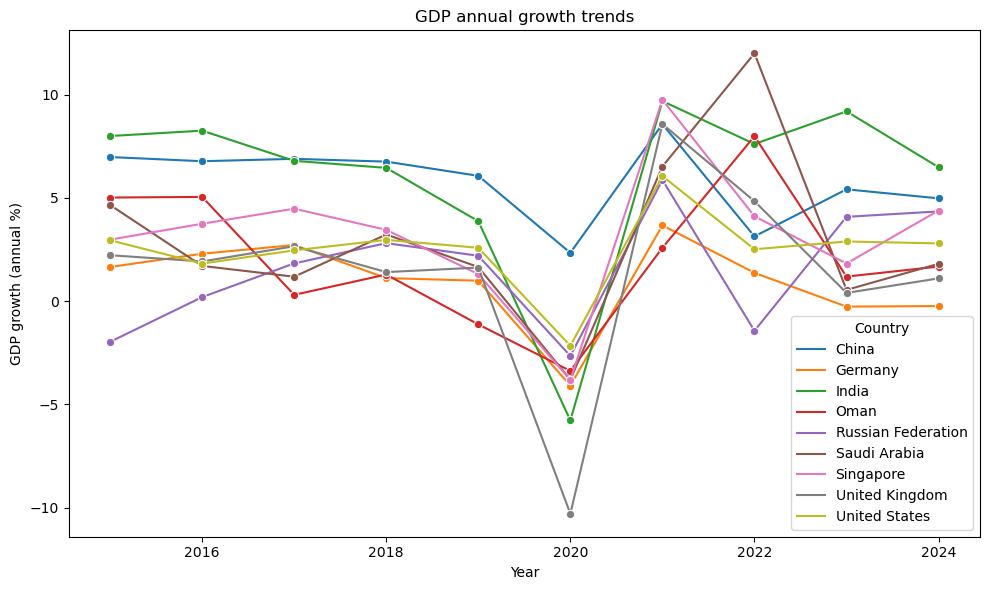

In [31]:
# Plot GDP annual growth trends
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_df,
    x="Year",
    y="GDP growth (annual %)",  # <-- adjust to your column name
    hue="Country Name",                      # or "Country Code"
    marker="o"
)

plt.title("GDP annual growth trends")
plt.ylabel("GDP growth (annual %)")
plt.xlabel("Year")
plt.legend(title="Country")
plt.tight_layout()
plt.show()

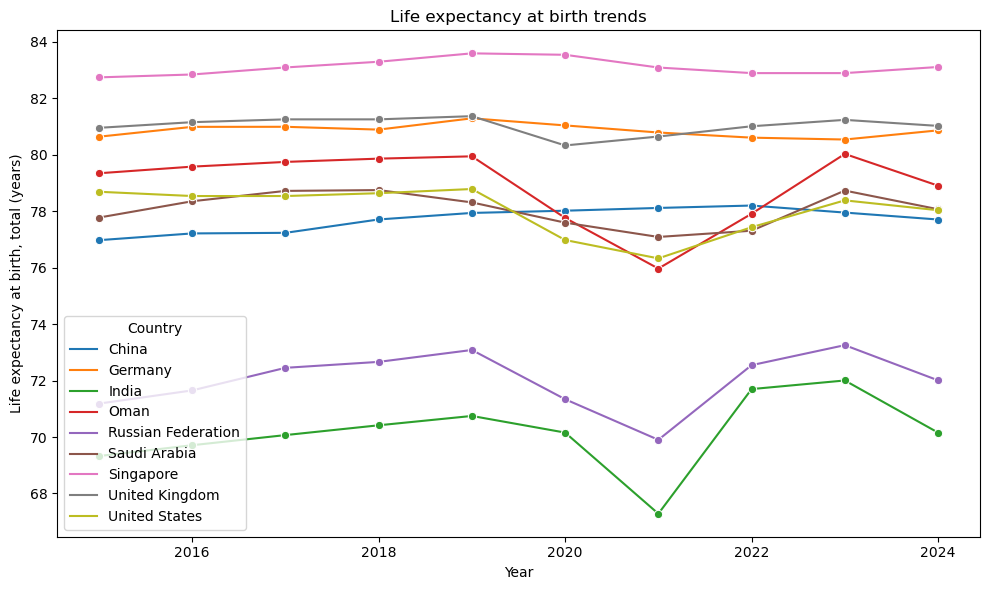

In [32]:
# Plot Life expectancy trends
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_df,
    x="Year",
    y="Life expectancy at birth, total (years)",  # <-- adjust to your column name
    hue="Country Name",                      # or "Country Code"
    marker="o"
)

plt.title("Life expectancy at birth trends")
plt.ylabel("Life expectancy at birth, total (years)")
plt.xlabel("Year")
plt.legend(title="Country")
plt.tight_layout()
plt.show()

Correlation coefficient: 0.60123836089028


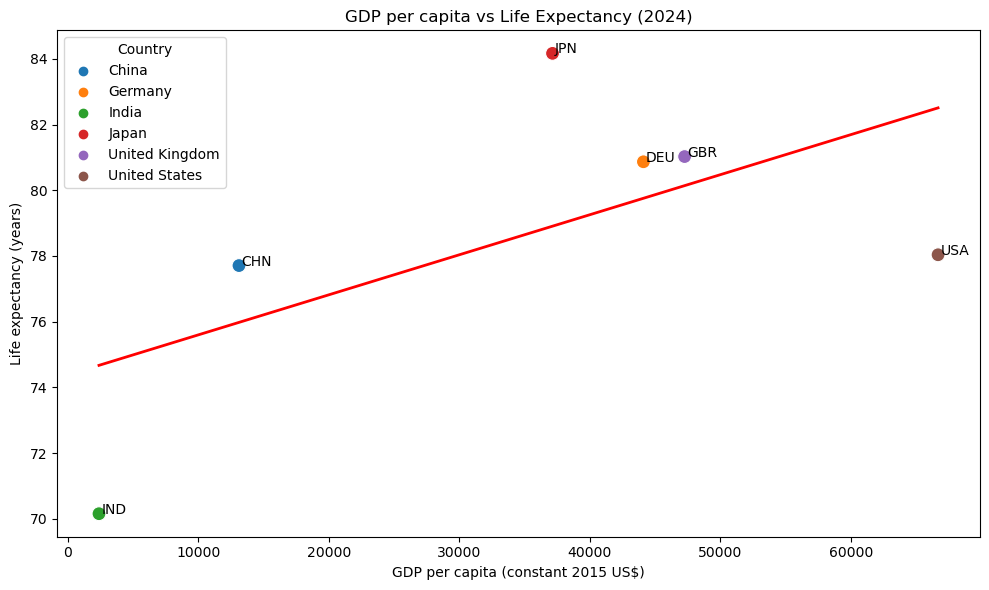

In [35]:
# GDP per capita vs Life Expectancy by Country

# Select countries
countries = ["CHN", "DEU", "IND", "JPN", "GBR", "USA"]
filtered_df = df_pivot[df_pivot["Country Code"].isin(countries)]

# Pick one year (example: 2024). You can change to any year you like.
year = 2024
year_df = filtered_df[filtered_df["Year"] == year]

# Compute the correlation coefficient across countries
corr = year_df["GDP per capita (constant 2015 US$)"].corr(
    year_df["Life expectancy at birth, total (years)"]
)
print("Correlation coefficient:", corr)  # Coeff > 0.7 indicates strong correlation

# Scatter + regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=year_df,
    x="GDP per capita (constant 2015 US$)",
    y="Life expectancy at birth, total (years)",
    scatter=True,
    ci=None,   # turn off confidence interval shading
    line_kws={"color": "red", "lw": 2}
)
# Scatter plot: GDP per capita vs Life Expectancy
#plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=year_df,
    x="GDP per capita (constant 2015 US$)",
    y="Life expectancy at birth, total (years)",
    hue="Country Name",
    s=100  # point size
)

# Add labels for countries (optional)
for i, row in year_df.iterrows():
    plt.text(
        row["GDP per capita (constant 2015 US$)"] + 200,   # small offset
        row["Life expectancy at birth, total (years)"],
        row["Country Code"]
    )

plt.title(f"GDP per capita vs Life Expectancy ({year})")
plt.xlabel("GDP per capita (constant 2015 US$)")
plt.ylabel("Life expectancy (years)")
plt.legend(title="Country")
plt.tight_layout()
plt.show()